In [1]:
import numpy as np
import pandas as pd
import os
import subprocess
import time
import matplotlib.pyplot as plt
import itertools
from copy import deepcopy

from rdkit import Chem
from rdkit.Chem import AllChem
import ase
from ase.io import read, write
from ase.units import Hartree
from ase.visualize import view

from ase.io.trajectory import Trajectory
import glob
import pickle

from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True

In [ ]:
def zpe_s_loop(Es, Eoh, Eo, Eooh, N=6):

    min_overpot = []
    last_opt_config_indx = None

    gsl = deepcopy(Es)
    gohl = deepcopy(Eoh)
    gol = deepcopy(Eo)
    goohl = deepcopy(Eooh)

    d0_list, d1_list, d2_list = [], [], []
    oc0_list, oc1_list, oc2_list = [], [], []

    run_once_flag = False

    for i in range(N):

        if last_opt_config_indx is not None:
            i0, i1, i2 = last_opt_config_indx

            if run_once_flag:
                gohl[~completedoh] -= goh_corr
                gol[~completedo] -= go_corr
                goohl[~completedooh] -= gooh_corr
            else:
                gsl += zpes - ss

            #### Perform frequency calc here, to obtain corrections di
            d0 = (zpeoh - soh)[i0]
            d1 = (zpeo - so)[i1]
            d2 = (zpeooh - sooh)[i2]
            ####

            # Running Mean
            d0_list.append(d0)
            d1_list.append(d1)
            d2_list.append(d2)

            goh_corr = np.mean(d0_list)
            go_corr = np.mean(d1_list)
            gooh_corr = np.mean(d2_list)

            # Update free energies by setting newly found d's
            # and setting other corrections to the mean of previously found corrections
            if i0 not in oc0_list:
                gohl[i0] += d0
            if i1 not in oc1_list:
                gol[i1] += d1
            if i2 not in oc2_list:
                goohl[i2] += d2

            oc0_list.append(i0)
            oc1_list.append(i1)
            oc2_list.append(i2)

            # Already completed
            completedoh = np.isin(np.arange(len(gohl)), oc0_list)
            completedo = np.isin(np.arange(len(gol)), oc1_list)
            completedooh = np.isin(np.arange(len(goohl)), oc2_list)

            gohl[~completedoh] += goh_corr
            gol[~completedo] += go_corr
            goohl[~completedooh] += gooh_corr
            run_once_flag = True
        
        GG = free_energy_multidim(gsl, gohl, gol, goohl)
        OO = GG.max(axis=3) - 1.23

        last_opt_config_indx = np.unravel_index(OO.argmin(), OO.shape)

        min_overpot.append(OO.min())
        print(i, last_opt_config_indx, OO.min())

-----

In [ ]:
os.getcwd()

In [2]:
### For automatically reloading import modules... allows you to run changes to code in jupyter without having to reload
%load_ext autoreload
%autoreload 2

# Read Dataframe containing entire chemical space
# path = os.getcwd() + '/data/'
# file = 'df_chemical_space_chons_4rings.json'
# p = pd.read_json(path+file, orient='split')

path = '/home/btpq/bt308495/Thesis/data/'
file = 'df_chemical_space_chons_4rings.json'
p = pd.read_json(path+file, orient='split')

# Change dir
# os.chdir('/home/scakolli/Thesis/osc_discovery/run')
os.chdir('/home/btpq/bt308495/Thesis/run')
sys.path.insert(1, '/home/btpq/bt308495/Thesis/')

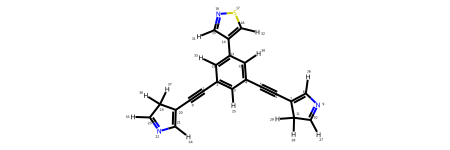

In [9]:
# Pick a random molecule in the space and get its smile string
rand_i = np.random.randint(315451)
smi = p.iloc[rand_i]['molecule_smiles']
# smi = 'C1=CC(C=Cc2cnnc(-c3cc(C=CC4=CCC=C4)cnn3)c2)=CC1'
# smi = 'C1=CSC(=C2C(C=Cc3ccco3)=CC=C2C=Cc2ccco2)S1'

# Draw chem
# p.iloc[rand_i]
rdkit_smi = Chem.AddHs(Chem.MolFromSmiles(smi))
rdkit_smi

In [10]:
from osc_discovery.cheminformatics.cheminformatics_misc import rdkit2ase

In [14]:
AllChem.EmbedMolecule(rdkit_smi)

0

In [15]:
test = rdkit2ase(rdkit_smi)

In [17]:
test.write('test.xyz')

-----

In [4]:
from photocatalysis.adsorption.tools import prepare_substrate
from photocatalysis.thermodynamics.tools import single_run, multi_run
from photocatalysis.thermodynamics.constants import dG1_REST, dG2_REST, dG3_REST, dG4_REST, SHE_VACUUM_POTENTIAL

In [7]:
# from photocatalysis.adsorption.tools import build_configurations, get_adsorbate_conformers
# from photocatalysis.adsorption.optimal_configurations import filter_configurations_with_symm, filter_configurations

In [ ]:
def free_energy_multidim(Gs, GOH, GO, GOOH, explicitly_broadcast=True):
    # Vectorized free energy expressions with numpy broadcasting
    # Gs : scalar, G*: arbitrary length numpy array
    # (OH_index, O_index, OOH_index)
    
    g1 = GOH[:, None, None] - Gs + dG1_CORR
    g2 = GO[None, :, None] - GOH[:, None, None] + dG2_CORR
    g3 = GOOH[None, None, :] - GO[None, :, None] + dG3_CORR
    g4 = Gs - GOOH[None, None, :] + dG4_CORR
    
    if explicitly_broadcast:
        tot_shape = len(GOH), len(GO), len(GOOH)
        g1b, g2b, g3b, g4b = explicitly_broadcast_to(tot_shape, g1, g2, g3, g4)
        G = np.moveaxis(np.array((g1b, g2b, g3b, g4b)), 0,3)
        return G
    else:
        return g1, g2, g3, g4

def explicitly_broadcast_to(shape, *gs_expres):
    # Fillout arrays
    out = []
    for g in gs_expres:
        out.append(np.broadcast_to(g, shape))
    return tuple(out)

In [ ]:
def grouped_by_sym(metric, sym_groupings):
    metric_grouped = [[metric[i] for i in symgroup] for symgroup in sym_groupings]
    return metric_grouped

def clean_configs_with_nans(configs):
    # Take a list of configs and resort them according to activesite, fill rest with nans...
    # makes accessing by acvt site indx easy
    d = dict.fromkeys(sub.info['nonH_atoms'], np.nan)
    cs = deepcopy(configs)

    for config in cs:
        actv = config.info['active_site']
        d[actv] = config

    return list(d.values())

In [8]:
# Prepare Substrate
calc_params = {'gfn':2, 'acc':0.2, 'etemp':298.15, 'strict':'', 'gbsa':'water'}
sub = prepare_substrate(smi, calc_params, multi_process_conf=2, multi_process_sp=4)

Number of rotatable bonds: 0, C1=CC(=c2ncc3onc4cccc4c23)C=C1
1) Embedding conformers (50). Using 2 processes
Took: 0.1892862319946289 s
2) Minimizing 50 conformers (mmff94)
Took: 0.34138011932373047 s
3) Pruning conformers (RMSD threshold: 0.35 Ang)
Took: 0.2658820152282715 s
Number of conformers found: 2


AssertionError: 'OMP_NUM_THREADS' env var not set, unparallelized calc, very slow

In [ ]:
sub = single_run(sub, runtype='vipea', **calc_params)
ipshe = sub.info['ip'] / 1. - SHE_VACUUM_POTENTIAL
ipshe

In [ ]:
sub_vacuum = single_run(sub, runtype='vipea', **{'acc':0.2, 'etemp':298.15, 'strict':''})
ipshe_vacuum = sub_vacuum.info['ip'] / 1. - SHE_VACUUM_POTENTIAL
ipshe_vacuum

## All sites

### Complete relaxation

In [ ]:
start = time.perf_counter()

### Build
configsOH, configsO, configsOOH = build_configurations(sub, key='nonH_atoms')

### Relax
oh_all = multi_run(configsOH, runtype='opt vtight', keep_folders=False, calc_kwargs=calc_params, multi_process=6)
o_all = multi_run(configsO, runtype='opt vtight', keep_folders=False, calc_kwargs=calc_params, multi_process=6)
ooh_all = multi_run(configsOOH, runtype='opt vtight', keep_folders=False, calc_kwargs=calc_params, multi_process=6)

### Filter
oh_all = filter_configurations(oh_all, sub)
o_all = filter_configurations(o_all, sub)
ooh_all = filter_configurations(ooh_all, sub)

### Info
print("Num configs", len(oh_all), len(o_all), len(ooh_all))
print("Relaxation Took", time.perf_counter()-start)

### ZPE, TS

In [ ]:
start = time.perf_counter()

### Hessian
oh_all = multi_run(oh_all, runtype='hess', keep_folders=False, calc_kwargs=calc_params, multi_process=6)
o_all = multi_run(o_all, runtype='hess', keep_folders=False, calc_kwargs=calc_params, multi_process=6)
ooh_all = multi_run(ooh_all, runtype='hess', keep_folders=False, calc_kwargs=calc_params, multi_process=6)

### Info
print("Total Time", time.perf_counter()-start)

In [ ]:
### All information
oh_nan, o_nan, ooh_nan = clean_configs_with_nans(oh_all), clean_configs_with_nans(o_all), clean_configs_with_nans(ooh_all)

eoh_nan = [config.info['energy'] if config is not np.nan else np.nan for config in oh_nan]
eo_nan = [config.info['energy'] if config is not np.nan else np.nan for config in o_nan]
eooh_nan = [config.info['energy'] if config is not np.nan else np.nan for config in ooh_nan]

zpeoh_nan = np.array([config.info['zpe'] if config is not np.nan else np.nan for config in oh_nan])
zpeo_nan = np.array([config.info['zpe'] if config is not np.nan else np.nan for config in o_nan])
zpeooh_nan = np.array([config.info['zpe'] if config is not np.nan else np.nan for config in ooh_nan])

soh_nan = np.array([config.info['entropy'] if config is not np.nan else np.nan for config in oh_nan])
so_nan = np.array([config.info['entropy'] if config is not np.nan else np.nan for config in o_nan])
sooh_nan = np.array([config.info['entropy'] if config is not np.nan else np.nan for config in ooh_nan])

In [ ]:
es = sub.info['energy']
zpes = sub.info['zpe']
ss = sub.info['entropy']

In [ ]:
eoh_all = [config.info['energy'] if config is not np.nan else np.nan for config in oh_all]
eo_all = [config.info['energy'] if config is not np.nan else np.nan for config in o_all]
eooh_all = [config.info['energy'] if config is not np.nan else np.nan for config in ooh_all]

zpeoh_all = np.array([config.info['zpe'] if config is not np.nan else np.nan for config in oh_all])
zpeo_all = np.array([config.info['zpe'] if config is not np.nan else np.nan for config in o_all])
zpeooh_all = np.array([config.info['zpe'] if config is not np.nan else np.nan for config in ooh_all])

soh_all = np.array([config.info['entropy'] if config is not np.nan else np.nan for config in oh_all])
so_all = np.array([config.info['entropy'] if config is not np.nan else np.nan for config in o_all])
sooh_all = np.array([config.info['entropy'] if config is not np.nan else np.nan for config in ooh_all])

In [ ]:
### Grouping for equivalent sites
qs_grouped = grouped_by_sym(sub.info['qs'], sub.info['equivalent_atoms_grouped'])

eoh_grouped = grouped_by_sym(eoh_nan, sub.info['equivalent_atoms_grouped'])
eo_grouped = grouped_by_sym(eo_nan, sub.info['equivalent_atoms_grouped'])
eooh_grouped = grouped_by_sym(eooh_nan, sub.info['equivalent_atoms_grouped'])

zpeoh_grouped = grouped_by_sym(zpeoh_nan, sub.info['equivalent_atoms_grouped'])
zpeo_grouped = grouped_by_sym(zpeo_nan, sub.info['equivalent_atoms_grouped'])
zpeooh_grouped = grouped_by_sym(zpeooh_nan, sub.info['equivalent_atoms_grouped'])

soh_grouped = grouped_by_sym(soh_nan, sub.info['equivalent_atoms_grouped'])
so_grouped = grouped_by_sym(so_nan, sub.info['equivalent_atoms_grouped'])
sooh_grouped = grouped_by_sym(sooh_nan, sub.info['equivalent_atoms_grouped'])

## Equivalent sites

In [ ]:
mol = Chem.MolFromSmiles(smi)
mol.__sssAtoms = [*sub.info['equivalent_atoms']]
mol

In [ ]:
sub.info['equivalent_atoms']

In [ ]:
print("Max diff in Energy (eV)")
print(np.nanmax([max(g) - min(g) for g in eoh_grouped]), np.nanmax([max(g) - min(g) for g in eo_grouped]), np.nanmax([max(g) - min(g) for g in eooh_grouped]))

In [ ]:
print("Max diff in zpe (eV)")
print(np.nanmax([max(g) - min(g) for g in zpeoh_grouped]), np.nanmax([max(g) - min(g) for g in zpeo_grouped]), np.nanmax([max(g) - min(g) for g in zpeooh_grouped]))

In [ ]:
print("Max diff in entropy (eV)")
print(np.nanmax([max(g) - min(g) for g in soh_grouped]), np.nanmax([max(g) - min(g) for g in so_grouped]), np.nanmax([max(g) - min(g) for g in sooh_grouped]))

In [ ]:
for g, e in zip(qs_grouped, sub.info['equivalent_atoms_grouped']):
    print(e, '|', max(g) - min(g))

Variation probably due to an actual difference in 3D environment, but also conformational and optimization related influences.

This approximation breaks down if the 2 supposedly equivalent sites have substantially different electronic environments. Errors on the order of 0.1-0.2 eV.

Charge difference heuristic max(qs) - min(qs) < 0.001 C.

### Complete relaxation

In [ ]:
### Build Configs
configsOH, configsO, configsOOH = build_configurations(sub, key='equivalent_atoms')

In [ ]:
start = time.perf_counter()
oh = multi_run(configsOH, runtype='opt vtight', keep_folders=False, calc_kwargs=calc_params, multi_process=6)
o = multi_run(configsO, runtype='opt vtight', keep_folders=False, calc_kwargs=calc_params, multi_process=6)
ooh = multi_run(configsOOH, runtype='opt vtight', keep_folders=False, calc_kwargs=calc_params, multi_process=6)

In [ ]:
### Filtering
oh = filter_configurations_with_symm(oh, sub)
o = filter_configurations_with_symm(o, sub)
ooh = filter_configurations_with_symm(ooh, sub)
print("Num configs", len(oh), len(o), len(ooh))
print("Took", time.perf_counter()-start)

### Crude, filter, then full relaxation

In [ ]:
### Crude Relaxation
start = time.perf_counter()
oh_crude = multi_run(configsOH, runtype='opt sloppy', keep_folders=False, calc_kwargs=calc_params, multi_process=6)
o_crude = multi_run(configsO, runtype='opt sloppy', keep_folders=False, calc_kwargs=calc_params, multi_process=6)
ooh_crude = multi_run(configsOOH, runtype='opt sloppy', keep_folders=False, calc_kwargs=calc_params, multi_process=6)

In [ ]:
### Filtering
oh_crude = filter_configurations_with_symm(oh_crude, sub)
o_crude = filter_configurations_with_symm(o_crude, sub)
ooh_crude = filter_configurations_with_symm(ooh_crude, sub)
print("Num configs", len(oh_crude), len(o_crude), len(ooh_crude))

In [ ]:
### Subsequent full Relaxation
oh_crude_full = multi_run(oh_crude, runtype='opt vtight', keep_folders=False, calc_kwargs=calc_params, multi_process=6)
o_crude_full = multi_run(o_crude, runtype='opt vtight', keep_folders=False, calc_kwargs=calc_params, multi_process=6)
ooh_crude_full = multi_run(ooh_crude, runtype='opt vtight', keep_folders=False, calc_kwargs=calc_params, multi_process=6)

In [ ]:
### Filtering
oh_crude_full = filter_configurations_with_symm(oh_crude_full, sub)
o_crude_full = filter_configurations_with_symm(o_crude_full, sub)
ooh_crude_full = filter_configurations_with_symm(ooh_crude_full, sub)
print("Num configs", len(oh_crude_full), len(o_crude_full), len(ooh_crude_full))
print("Took", time.perf_counter()-start)

Its often apparent early in the relaxation whether a site is stable or not (whether it destroys the substrate or volatalizes off the site). Prune redundant and unstable configurations early in the relaxation.

1. Double O configs are common
2. Volatization to another site is common
3. No need to further optimize a destroyed substrate

In [ ]:
eoh = np.array([t.info['energy'] for t in oh])
eo = np.array([t.info['energy'] for t in o])
eooh = np.array([t.info['energy'] for t in ooh])

eoh_crude = np.array([t.info['energy'] for t in oh_crude])
eo_crude = np.array([t.info['energy'] for t in o_crude])
eooh_crude = np.array([t.info['energy'] for t in ooh_crude])

asoh = [t.info['active_site'] for t in oh]
aso = [t.info['active_site'] for t in o]
asooh = [t.info['active_site'] for t in ooh]

activesites = [[i, j, k] for i, j, k in itertools.product(asoh, aso, asooh)]
activesites = np.array(activesites).reshape(len(asoh), len(aso), len(asooh), 3)
eoh_crude = np.delete(eoh_crude, 5)

### Generating additional adsorbate configurations

Force fields turn out to be not so good for geometries... but still useful for gnerating addition conformations

In [ ]:
# Generate additional conformers, and optimize them with ff's
start = time.perf_counter()
add_oh_confs = [get_adsorbate_conformers(config) for config in oh]
add_o_confs = [get_adsorbate_conformers(config) for config in o]
add_ooh_confs = [get_adsorbate_conformers(config) for config in ooh]
print("Took", time.perf_counter() - start)

In [ ]:
# Relax them at tight binding level
add_oh = multi_run(add_oh_confs, runtype='opt vtight', keep_folders=False, calc_kwargs=calc_params, multi_process=6)
add_o = multi_run(add_o_confs, runtype='opt vtight', keep_folders=False, calc_kwargs=calc_params, multi_process=6)
add_ooh = multi_run(add_ooh_confs, runtype='opt vtight', keep_folders=False, calc_kwargs=calc_params, multi_process=6)

In [ ]:
# Filter and update
oh_opt = filter_configurations(oh + add_oh, sub)
o_opt = filter_configurations(o + add_o, sub)
ooh_opt = filter_configurations(ooh + add_ooh, sub)
print("Took Total", time.perf_counter() - start)

In [ ]:
eoh_opt = np.array([t.info['energy'] for t in oh_opt])
eo_opt = np.array([t.info['energy'] for t in o_opt])
eooh_opt = np.array([t.info['energy'] for t in ooh_opt])

In [ ]:
print('Num configs', len(oh), len(o), len(ooh))
print('New configs', np.count_nonzero(eoh_opt - eoh < 0), np.count_nonzero(eo_opt - eo < 0), np.count_nonzero(eooh_opt - eooh < 0))

In [ ]:
print('Min difference (eV)')
print(np.min(eoh_opt - eoh), np.min(eo_opt - eo), np.min(eooh_opt - eooh))

Generating additional conformations with EKTG/FFs leads to better sampling of the PES for a given active site.. but it essentially requires double the computational time. Can resolve errors on the order of ~0.1 eV.

### Free Energy and overpotentials

#### ZPE, TS

In [ ]:
start = time.perf_counter()

### Hessian
oh = multi_run(oh, runtype='hess', keep_folders=False, calc_kwargs=calc_params, multi_process=6)
o = multi_run(o, runtype='hess', keep_folders=False, calc_kwargs=calc_params, multi_process=6)
ooh = multi_run(ooh, runtype='hess', keep_folders=False, calc_kwargs=calc_params, multi_process=6)

### Info
print("Total Time", time.perf_counter()-start)

In [ ]:
# Info
zpeoh = np.array([config.info['zpe'] if config is not np.nan else np.nan for config in oh])
zpeo = np.array([config.info['zpe'] if config is not np.nan else np.nan for config in o])
zpeooh = np.array([config.info['zpe'] if config is not np.nan else np.nan for config in ooh])

soh = np.array([config.info['entropy'] if config is not np.nan else np.nan for config in oh])
so = np.array([config.info['entropy'] if config is not np.nan else np.nan for config in o])
sooh = np.array([config.info['entropy'] if config is not np.nan else np.nan for config in ooh])

#### with (ZPE-TS) correction

enumerating active sites... lowest overpotential site would be our active site?

In [ ]:
# Free energies
gs = es + zpes - ss
goh = eoh + zpeoh - soh
go = eo + zpeo - so
gooh = eooh + zpeooh - sooh

# G matrix, MAD, overpot, rate determining step
G = free_energy_multidim(gs, goh, go, gooh)
overpot = G.max(axis=3) - 1.23
mad = abs(G-1.23).sum(axis=3)
spread = G.max(axis=3) - G.min(axis=3)
rds = G.argmax(axis=3)

# Sorting
arg_0 = np.unravel_index(overpot.argsort(axis=None, kind='stable'), overpot.shape)
indxs_0 = np.dstack(arg_0)[0]

In [ ]:
eoh_crude.argmin(), eo_crude.argmin(), eooh_crude.argmin()

In [ ]:
stable_indx = eoh.argmin(), eo.argmin(), eooh.argmin()
stable_indx_zpets = goh.argmin(), go.argmin(), gooh.argmin()
stable_indx

In [ ]:
G[stable_indx].max()

In [ ]:
# unravled_argsorted_overpot = np.unravel_index(argsorted_overpot, overpot.shape)
# lexargsorted_overpot_then_mad = np.lexsort((mad.flatten()[argsorted_overpot], overpot.flatten()[argsorted_overpot]))
# argsorted_overpot_then_mad = argsorted_overpot[lexargsorted_overpot_then_mad]
# unraveled_argsorted_overpot_then_mad = np.unravel_index(argsorted_overpot_then_mad, overpot.shape)

In [ ]:
indxs_0[0], overpot[*indxs_0[0]]

In [ ]:
G[0,1,2]

In [ ]:
for config_index in indxs_0:
    print(config_index, '|', overpot[*config_index], '|', rds[*config_index])

#### visualizing sites

In [ ]:
from rdkit.Chem import Draw
import ast

In [ ]:
def mol_with_specific_atom_index(mol, indices=None):
    if indices is not None:
        for atom in mol.GetAtoms():
            if atom.GetIdx() in indices:
                atom.SetAtomMapNum(atom.GetIdx())
    else:
        for atom in mol.GetAtoms():
            atom.SetAtomMapNum(atom.GetIdx())
    return mol

In [ ]:
def config_num_to_activesite_numerized(arguments):
    # np.dstacked (Nx3) array of config indices as input
    out = []
    for argg in arguments:
        if isinstance(aso[argg[1]], str):
            a = list((asoh[argg[0]], *ast.literal_eval(aso[argg[1]]), asooh[argg[2]]))
        else:
            a = list((asoh[argg[0]], aso[argg[1]], asooh[argg[2]]))
        
        c = [int(b) for b in a]
        out.append(c)
    
    return out

In [ ]:
N = 300

args = indxs_0[:N:20]
# args = np.dstack(unraveled_argsorted_overpot_then_mad)[0][:N:20]
# args = activesites[argsorted_overpot][:N]
# args = argsorted_overpot_then_mad[:N:20]

l = []
ms = []
for arg in args:
    overpotential = overpot[*arg]
    meanabsdiff = mad[*arg]
    #overpotential = overpot.flatten()[arg]
    #meanabsdiff = mad.flatten()[arg]
    
    # |as:{arg[0], arg[1], arg[2]}, 
    l.append(f'|over:{round(overpotential, 4)}eV, mad:{round(meanabsdiff, 4)}|')
    
    m = deepcopy(rdkit_smi)
    #m.GetAtomWithIdx(int(arg[0])).SetProp('atomNote', 'OH')
    #m.GetAtomWithIdx(int(arg[1])).SetProp('atomNote', 'O')
    #m.GetAtomWithIdx(int(arg[2])).SetProp('atomNote', 'OOH')
    m = Chem.RemoveHs(m)
    #asite = activesites[np.unravel_index(arg, overpot.shape)].astype(int)
    asite = activesites[*arg]
    #m = mol_with_specific_atom_index(m, indices=[*asite])
    ms.append(m)

In [ ]:
overpot.max()

In [ ]:
Draw.MolsToGridImage(ms, legends=l, highlightAtomLists=config_num_to_activesite_numerized(indxs_0), subImgSize=(500,500))

What do we count as an active site exactly? Far apart configurations also work?

#### w/o ZPE-TS correction

In [ ]:
gs = es
goh = eoh
go = eo
gooh = eooh

Gcrude = free_energy_multidim(gs, goh, go, gooh)
overpotcrude = Gcrude.max(axis=3) - 1.23
rdscrude = Gcrude.argmax(axis=3)

In [ ]:
arg_1 = np.unravel_index(overpotcrude.argsort(axis=None, kind='stable'), overpotcrude.shape)
indxs_1 = np.dstack(arg_1)[0]

In [ ]:
for config_index in indxs_1:
    print(config_index, '|', overpotcrude[*config_index], '|', rdscrude[*config_index])

In [ ]:
indxs_0[0], overpot[*indxs_0[0]]

#### ZPE-TS distb

In [ ]:
corr1 = (zpeoh - soh) - (zpes - ss)
corr2 = (zpeo - so) - (zpeoh - soh)[:, None]
corr3 = (zpeooh - sooh) - (zpeo - so)[:, None]
corr4 = (zpes - ss) - (zpeooh - sooh)

In [ ]:
plt.hist(corr1, label='1')
plt.hist(corr2.flatten(), label='2')
plt.hist(corr3.flatten(), label='3')
plt.hist(corr4, label='4')
plt.legend()

In [ ]:
zpe_s_loop(es, eoh, eo, eooh)

#### Not fully relaxed

In [ ]:
zpe_s_loop(es, eoh_crude, eo_crude, eooh_crude)

1) Fully Relaxing 28*3 configs took 184 sec, Frequency analysis on 21*14*15 configs took 235 sec
2) Relaxing 15*3 equivalent configs took 108 sec, Freq. analysis on 11*8*8 configs took 133
2a) Stop and go relaxing 15*15*15 / 12*8*8 equivalent configs took 82 sec
3) Generating addition FF confs and relaxing them, 75 sec

75sec (conf generation)
1) 419sec (full, 100%) 
2) 241sec (Equivalent, 57%)
3) 215sec (stop and go, 51%)
4) 40 sec + 20 sec ZPEs + 20 sec relax (crude, 19%)

In [ ]:
gs = es #+ ss - zpes
goh = eoh_crude #+ zpeoh - soh
go = eo_crude #+ zpeo - so
gooh = eooh_crude #+ zpeooh - sooh

Gcrude = free_energy_multidim(gs, goh, go, gooh)
overpotcrude = Gcrude.max(axis=3) - 1.23
rdscrude = Gcrude.argmax(axis=3)

In [ ]:
np.mean(eoh_crude - eoh), np.mean(eo_crude - eo), np.mean(eooh_crude - eooh)

In [ ]:
plt.scatter(overpot.flatten(), overpotcrude.flatten())
plt.plot(overpot.flatten(), overpot.flatten(), 'r')
plt.xlabel('Overpotential Exact')
plt.ylabel('Overpotential Crude')

In [ ]:
rdscrude[np.where(overpotcrude > overpot)]

In [ ]:
np.mean(overpotcrude - overpot)